# Plots for validated Data 

In [8]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,imp,os,shutil
from pandas import json_normalize
import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from collections import OrderedDict
import seaborn as sns
from scipy.interpolate import interp1d
from IPython.display import display, Markdown
pd.option_context('display.max_columns', -1)
pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution
#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

#### Create txname/process translator

In [2]:
# processDict = {'TChiWZ' : r'$\tilde{\chi}_1^\pm \, \tilde{\chi}_2^0 \to W^{(*)} Z^{(*)}\, \tilde{\chi}_1^0 \tilde{\chi}_1^0$',
#               'TChiWH' : r'$\tilde{\chi}_1^\pm \, \tilde{\chi}_2^0 \to W h\, \tilde{\chi}_1^0 \tilde{\chi}_1^0$',
#               'TChiWW' : r'$\tilde{\chi}_1^\pm \, \tilde{\chi}_1^\mp \to W W \, \tilde{\chi}_1^0 \tilde{\chi}_1^0$',
#               'TDTM1F,TDTM2F' : r'$\tilde{\chi}_1^\pm \to \pi^\pm \tilde{\chi}_1^0$, DT'}
# def convertLabel(label):
#     newlabel = label[:]
#     #Replace txnames by process
#     for txlabel,proc in processDict.items():
#         newlabel = newlabel.replace(txlabel,proc) 
#     #Remove off-shell Ws and Zs from ATLAS analyses (since they only appear in on-shell cases)
#     if 'ATLAS' in newlabel:
#         newlabel = newlabel.replace('W^{(*)} Z^{(*)}', 'W Z')
#     return newlabel

In [9]:
#Merge with SModelS DataFrame
dataDF = pd.read_pickle('/home/yoxara/2MDM/Validated_Data/results/Simp_scanResults_Obs.pcl')
# print(dataDF.columns.values.tolist()) #Print all columns names

#### Set r = 0 for points with no results 

In [10]:
#Set points without results with r == 0
dataDF.fillna(value={'ExptRes.result0.r' : 0.0},inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)

#### Define exclusions

In [11]:
#Add simple flag for excluded points:
dataDF['excludedLHC'] = dataDF['ExptRes.result0.r'] > 1.0

### Get points excluded:

In [12]:
excluded = dataDF[dataDF['excludedLHC'] == True]

allowed = dataDF[(dataDF['excludedLHC'] == False)]


print('Total number of points = %i' %len(dataDF))
print('Total excluded (LHC) = %i'%(len(excluded)))
print('Total allowed = %i\n'%(len(allowed)))

# print('Total excluded (r > %1.2f) = %i'%(rscale,len(excludedSC)))
# print('Total allowed (r > %1.2f) = %i'%(rscale,len(allowedSC)))


Total number of points = 34
Total excluded (LHC) = 0
Total allowed = 34



### Create analysis label for excluded points

In [16]:
anas = excluded['ExptRes.result0.AnalysisID'].value_counts()
anas.sort_values(inplace=True,ascending=False)

    
labels = []
for index, row in excluded.iterrows():
    ana = row['ExptRes.result0.AnalysisID']
    txList = sorted(row['ExptRes.result0.TxNames'])
    label = ana + ' (' + ','.join(txList) + ')'
    label = label.replace('off','') #Group together on and off-shell topologies
    labels.append(label)
excluded['label'] = labels


In [20]:
nexcluded = [[len(excluded[excluded['label'] == label]),label] for label in excluded['label'].unique()]
nexcluded = sorted(nexcluded,reverse=True)
nexcluded = np.array(nexcluded)
print(excluded.shape)


(0, 58)


In [23]:

for label in nexcluded[:,1]:
    print(label+': %i'%len(excluded[excluded['label'] == label]))

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

### Define colors and plotting order

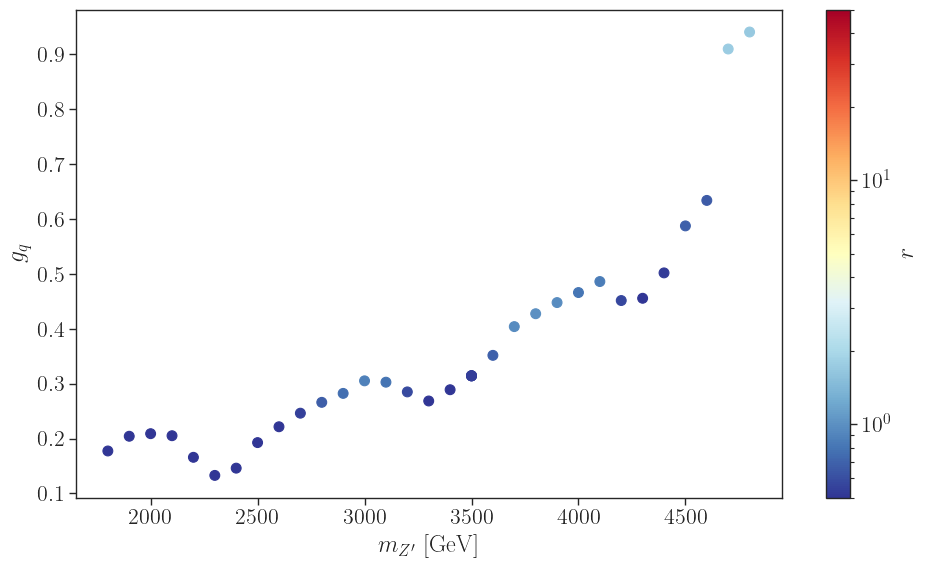

In [31]:
plt.figure(figsize=(10,6))
x = dataDF['mass.5000001']
y = dataDF['extpar.4']
c = dataDF['ExptRes.result0.r_expected']
x = x[c.argsort()]
y = y[c.argsort()]
c = c[c.argsort()]
plt.scatter(x,y,c=c,s=50,cmap=cm, norm=LogNorm(vmin=1e-1,vmax=1e1))
# # plt.plot([x.min(),x.max()],[x.min(),x.max()],'--')
plt.colorbar(label=r'$r$')
plt.xlabel(r'$m_{Z^{\prime}}$ [GeV]')
plt.ylabel(r'$g_{q}$')
plt.clim(5e-1,5e1)
# plt.xscale('log')
# plt.yscale('log')
plt.tight_layout()
# plt.savefig('.png')
plt.show()

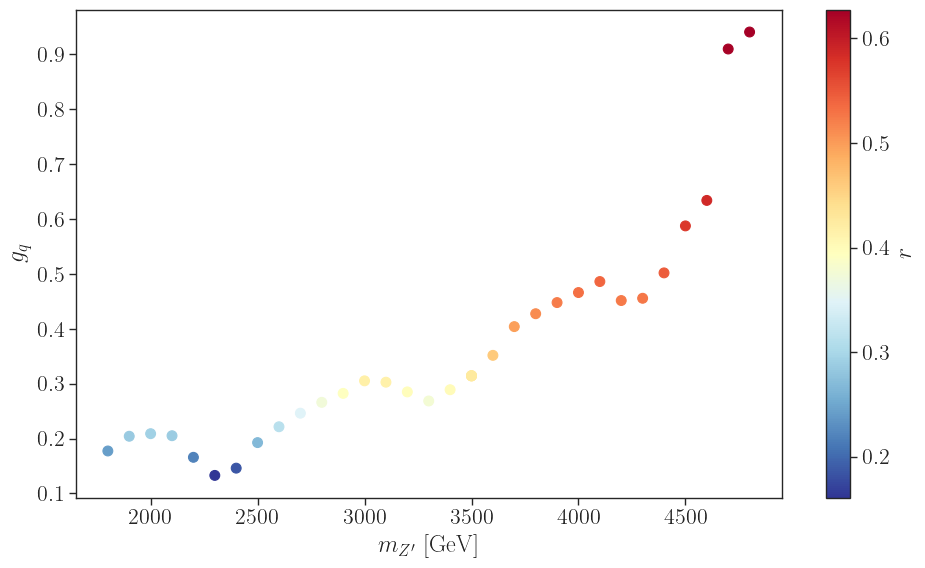

In [29]:
deleteCurves = ['CMS-EXO-19-012']
anas = excluded['label'].value_counts()
anas.sort_values(inplace=True,ascending=False)
plt.figure(figsize=(10,6))
x = dataDF['mass.5000001']
y = dataDF['extpar.4']
c = dataDF['ExptRes.result0.r']
for ana in anas.index:
    if not ana in excCurves: continue
    if any(val in ana for val in deleteCurves): continue
    curve = excCurves[ana]
    color = colorDict[ana]
    plt.plot(curve[:,0],curve[:,1],linewidth=3,linestyle='-',color=color)

plt.scatter(x,y,c=c,s=50,cmap=cm)
# plt.plot([x.min(),x.max()],[x.min(),x.max()],'--')
plt.colorbar(label=r'$r$')
plt.xlabel(r'$m_{Z^{\prime}}$ [GeV]')
plt.ylabel(r'$g_{q}$')
#plt.ylim(0,600)
#plt.xlim(0,800)
plt.tight_layout()
plt.show()